In [1]:
from functools import partial
from sqlite3 import connect

import astropy.units as u
from icecream import ic, install
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.phase as ph

install() # icecream will now work in imported packages

%load_ext autoreload
%autoreload 2


In [2]:
conn = connect("../../django/TargetDB/db.sqlite3")

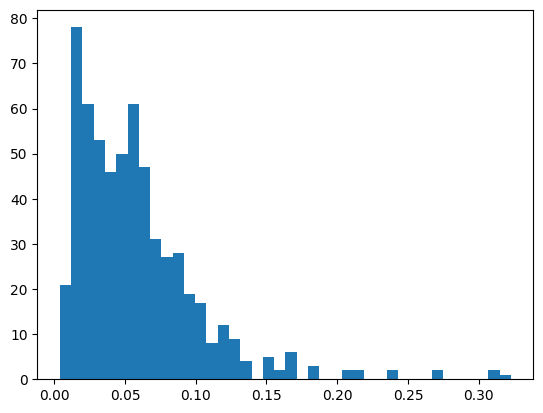

np.float64(0.04987849598378351)

In [3]:
# first, look at what percent the duration of an eclipse is of the system's period
percent_eclipse = pd.read_sql("""
select duration/period
from tom_binaryparameters
where duration = duration
;
""",
conn)

fig, ax = plt.subplots()
ax.hist(percent_eclipse["duration/period"], 40)
plt.show()

median_phase_percent = np.median(percent_eclipse["duration/period"])
median_phase_percent

Create a TargetList based on the targets in Table 1.
Next, break targets into categories depending on the fullness of their ephemeris data.
A given System/component ephemeris entry may be:
* Full: t0, period, and duration are present
* Partial: duration is missing but t0 and period are present
* Zero: no ephemeris data exists

Characterize each row of the ephemeris table.  
Then, for each QuadEB, collect the 4 categories (F, P, or Z) for its ephemerides.
Since there is system symmetry and component symmetry, sort these letters alphabetically.
Use this sorted 4 letter sequence as the label for that target.
Determine if a speckle observation captured a target during eclipse based on their 4-letter label.
  * Category F: Use the ephemeris data directly
  * Category P: Use the median phase percent calculated above in lieu of duration
  * Category Z: Assume system was not in eclipse


In [4]:
phase_event_defs = [
    ph.PhaseEventDef(
        "Not in Eclipse", partial(ph.calc_time_of_gress, ingress=False, synthetic_phase_percent=median_phase_percent)
    ),
    ph.PhaseEventDef("Eclipse", partial(ph.calc_time_of_gress, ingress=True, synthetic_phase_percent=median_phase_percent)),
]

creator = tlc.TargetListCreator(name="All Targets", connection=conn)
creator.steps = [
    tlc.add_targets,
    tlc.add_lists,
    partial(tlc.filter_targets, criteria=lambda df: df["List Table 1 Targets"]),
    partial(tlc.hide_cols, prefix="List "),
    partial(tlc.filter_targets, inverse=True, criteria=lambda df: df["Target Name"] == "TIC 168789840"),  # exclude Sextuple EB
    tlc.add_ephemerides,
    tlc.add_speckle,
    partial(tlc.add_speckle_phase, phase_event_defs=phase_event_defs),
    partial(tlc.add_side_status, phase_event_defs=phase_event_defs, side_state="Eclipse"),
]
tl = creator.calculate(verbose=False)
len(tl.target_list)

33

In [218]:
Time("2024-01-01", format="iso").jd

np.float64(2460310.5)

In [ ]:
foo = tl.other_lists["Speckle Observations"]
print(len(foo[foo["Speckle Mid"] < 2460310]))
bar = foo[foo["Speckle Mid"] < 2460310].sort_values(["Target Name", "Speckle Mid"])
from astropy.time import Time
[f"{target_name} {Time(date, format="jd").decimalyear - 2000:.5f}" for target_name, date in zip(bar.index, bar["Speckle Mid"])]


50


['TIC 161043618 22.35715',
 'TIC 161043618 23.35149',
 'TIC 200094011 22.73841',
 'TIC 239872462 22.74372',
 'TIC 25818450 22.74344',
 'TIC 266771301 22.74110',
 'TIC 266771301 22.87175',
 'TIC 283940788 22.74069',
 'TIC 283940788 22.87172',
 'TIC 283940788 23.67510',
 'TIC 286470992 22.74102',
 'TIC 286470992 22.86632',
 'TIC 307119043 22.74338',
 'TIC 317863971 22.87238',
 'TIC 317863971 23.18129',
 'TIC 322727163 22.74326',
 'TIC 328181241 22.73799',
 'TIC 328181241 23.66694',
 'TIC 336882813 22.74376',
 'TIC 336882813 23.18112',
 'TIC 344541836 22.36013',
 'TIC 344541836 22.74327',
 'TIC 344541836 22.87168',
 'TIC 348651800 22.87266',
 'TIC 348651800 23.18132',
 'TIC 367448265 22.74369',
 'TIC 367448265 23.18385',
 'TIC 367448265 23.67531',
 'TIC 375325607 22.87147',
 'TIC 389836747 22.74064',
 'TIC 389836747 22.74076',
 'TIC 389836747 22.86637',
 'TIC 427092089 22.74332',
 'TIC 438226195 22.87215',
 'TIC 470710327 22.74342',
 'TIC 470710327 23.79756',
 'TIC 470710327 23.79778',
 '

: 

In [ ]:
ephem = tl.other_lists["Ephemerides"]

# set category for each row of ephemerides table - these will be either M or P
ephem["Category"] = ["F" if duration == duration else "P" for duration in ephem["Duration"]]

# detect missing system/component combinations and create NaN rows for them with category M
blank_row_data = {column: float("NaN") for column in ephem.columns}
blank_row_data["Category"] = "Z"
for _, row in tl.target_list.iterrows():
    target_name = row["Target Name"]
    for system in ["A", "B"]:
        for member in ["a", "b"]:
            target_ephem = tl.other_lists["Ephemerides"].loc[target_name]
            ephemeris = target_ephem[(target_ephem["System"] == system) & (target_ephem["Member"] == member)]
            if len(ephemeris) == 0:
                new_row = blank_row_data.copy()
                new_row["System"] = system
                new_row["Member"] = member
                ephem = pd.concat([ephem, pd.DataFrame([new_row], index=pd.Index([target_name], name=ephem.index.name))])

# make new table listing target name and concatenated system/member categories
target_categories = ephem.reset_index().groupby("Target Name")["Category"].apply(lambda x: "".join(sorted(x))).to_frame(name="Category")

targets_by_category = {category: list(target_name) for category, target_name in target_categories.groupby("Category").groups.items()}

target_categories.pivot_table(index="Category", aggfunc="size")


33


Category
FFFF    16
FFPZ    12
FFZZ     1
PPPZ     3
PPZZ     1
dtype: int64

In [5]:
tl.other_lists["SIDE Observations"]

,Speckle Session,JD Mid,UTC Mid,System,Member,SIDE Type
Target Name,,,,,,
TIC 161043618,61,2.459711e+06,2022-05-11 08:39:00,A,b,Exact
TIC 161043618,1578,2.460364e+06,2024-02-23 08:34:00,B,b,Exact
TIC 161043618,1580,2.460364e+06,2024-02-23 08:55:00,B,b,Exact
TIC 283940788,484,2.459899e+06,2022-11-15 04:13:30,A,a,Exact
TIC 283940788,185,2.459851e+06,2022-09-28 08:25:00,A,b,Exact
TIC 283940788,1224,2.460192e+06,2023-09-04 09:52:30,A,b,Exact
TIC 286470992,212,2.459851e+06,2022-09-28 11:19:30,B,a,Exact
TIC 317863971,511,2.459899e+06,2022-11-15 10:01:30,A,b,Exact
TIC 317863971,611,2.460012e+06,2023-03-08 04:08:00,B,a,Exact


In [225]:
side = tl.other_lists["SIDE Observations"]
serrendipitous_eclipses = side.reset_index()[["Target Name", "UTC Mid", "System", "Member", "SIDE Type"]]
serrendipitous_eclipses.to_csv("Serendipitous Eclipses.csv", index=False)
speckle = tl.other_lists["Speckle Observations"]
speckle = speckle[speckle["Speckle Mid"] < 2460310.5]  # paper only includes speckle before 2024
print(f"{len(serrendipitous_eclipses)} eclipses out of {len(speckle)} observations")
serrendipitous_eclipses

23 eclipses out of 50 observations


,Target Name,UTC Mid,System,Member,SIDE Type
0,TIC 161043618,2022-05-11 08:39:00,A,b,Exact
1,TIC 161043618,2024-02-23 08:34:00,B,b,Exact
2,TIC 161043618,2024-02-23 08:55:00,B,b,Exact
3,TIC 283940788,2022-11-15 04:13:30,A,a,Exact
4,TIC 283940788,2022-09-28 08:25:00,A,b,Exact
5,TIC 283940788,2023-09-04 09:52:30,A,b,Exact
6,TIC 286470992,2022-09-28 11:19:30,B,a,Exact
7,TIC 317863971,2022-11-15 10:01:30,A,b,Exact
8,TIC 317863971,2023-03-08 04:08:00,B,a,Exact
9,TIC 336882813,2022-09-29 11:21:30,B,a,Exact


In [200]:
from glob import glob
observation_files = list(glob("../../astropaul/test/asd/DSSI Observations/*.csv"))
dssi_observations = pd.concat([pd.read_csv(file) for file in observation_files])


In [211]:

dssi_observations["TIC ID"] = [target_name if target_name.startswith("TIC") else "" for target_name in dssi_observations["Target Name"]]
len(dssi_observations[dssi_observations["TIC ID"] != ""])
len(dssi_observations[dssi_observations["Target Name"].str.startswith("H3")])

190

---

In [4]:
%load_ext autoreload
%autoreload 2

from functools import partial
from sqlite3 import connect

import astroplan as ap
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.lbt as lbt
import astropaul.html as html
import astropaul.phase as ph
import astropaul.priority as pr

session = tlc.ObservingSession(ap.Observer.at_site("APO"))
session.add_day_range("2025-05-01", "2025-05-03")
phase_event_defs = [
    ph.PhaseEventDef("Not in Eclipse", partial(ph.calc_time_of_gress, ingress=False)),
    ph.PhaseEventDef("Eclipse", partial(ph.calc_time_of_gress, ingress=True)),
]

creator = tlc.TargetListCreator("test", connection=connect("../../django/TargetDB/db.sqlite3"), observing_session=session, phase_event_defs=phase_event_defs)
# creator = tlc.TargetListCreator("test", connect("asd.db"), observing_session=session, phase_event_defs=phase_event_defs)
creator.steps = [
    tlc.add_targets,
    tlc.add_speckle,
    # tlc.add_pepsi,
    tlc.add_lists,
    partial(tlc.filter_targets, criteria=lambda df: df["List Table 1 Targets"]),
    tlc.add_ephemerides,
    partial(tlc.add_system_configuration, table_name="Speckle Observations", time_column="Speckle Mid"), 
    # tlc.add_observability,
    # tlc.add_phase_events,
    # tlc.add_dssi_phase,
    # tlc.add_side_status,
]

tl = creator.calculate(verbose=True)
tl.target_list[tl.target_list["Target Name"] == "TIC 344541836"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 214 targets, step=<function add_targets at 0x0000023CBE3E7880>
 214 targets, step=<function add_speckle at 0x0000023CBE5E4E00>
 214 targets, step=<function add_lists at 0x0000023CBE5E4F40>
  34 targets, step=functools.partial(<function filter_targets at 0x0000023CBE5E5440>, criteria=<function <lambda> at 0x0000023CEA56C0E0>)
  34 targets, step=<function add_ephemerides at 0x0000023CBE5E4FE0>
  34 targets, step=functools.partial(<function add_system_configuration at 0x0000023CBE5E5580>, table_name='Speckle Observations', time_column='Speckle Mid')
test
Criteria
    lambda df: df["List Table 1 Targets"]),
34 targets:
      33 QuadEB
       1 SextEB
Column Count (primary, secondary):
    Target: (1, 2)
    Count: (1, 0)
    List : (0, 12)
Associated tables:
     154 rows, 13 columns: Speckle Observations
     118 rows,  8 columns: Ephemerides



,Target Name,Target Source,Target Type,Num Speckle,List Featured targets,List Gemini 2024B Proposal,List Gemini 2025A Proposal,List HQND,List Kostov 2022,List Kostov 2023,List LBT 2023-12-06,List LBT 2023B,List LBT 2024B,List LBT 2025A,List Speckle Resolved,List Table 1 Targets
id,,,,,,,,,,,,,,,,
5094,TIC 344541836,Kostov 2022 arXiv:2202.05790,QuadEB,6,False,False,False,False,True,False,False,False,False,False,True,True


In [6]:
# tl.other_lists["DSSI Phases"]
tl.other_lists["Ephemerides"]
all_targets = tl.target_list["Target Name"].unique()
foo = tl.other_lists["Speckle Observations"].copy().sort_values(["Target Name", "Speckle Start"])
# foo = foo[(foo["System A Eclipse"] != "") | (foo["System B Eclipse"] != "") | (foo["System C Eclipse"] != "")].sort_values(["Target Name", "Speckle Start"]).drop(["Speckle Session", "Speckle Sequences", "Speckle Mid", "Speckle End", "Speckle Start"], axis=1)
foo = foo[foo["Target Name"].isin(all_targets)]
foo = foo[foo["Speckle Mid UTC"] < "2024-01-01"]
from astropy.time import Time

foo["Decimal Year"] = [f"{dyear - 2000:.5f}" for dyear in Time(foo["Speckle Mid"], format="jd").decimalyear]
foo = foo[
    [
        "Target Name",
        "Speckle Mid UTC",
        "Decimal Year",
        "System A Eclipse",
        "System A Duration Percent",
        "System B Eclipse",
        "System B Duration Percent",
        "System C Eclipse",
        "System C Duration Percent",
    ]
]
foo.to_csv("Speckle Side Status.csv", index=False)
lo, hi = 0, 1
bar = foo[
    (foo["System A Duration Percent"] > lo) & (foo["System A Duration Percent"] < hi)
    | (foo["System B Duration Percent"] > lo) & (foo["System B Duration Percent"] < hi)
    | (foo["System C Duration Percent"] > lo) & (foo["System C Duration Percent"] < hi)
]
bar.to_csv("Strong Side Candidates.csv", index=False)
print(len(foo), len(bar))
bar[bar["Target Name"] == "TIC 344541836"]

51 17


,Target Name,Speckle Mid UTC,Decimal Year,System A Eclipse,System A Duration Percent,System B Eclipse,System B Duration Percent,System C Eclipse,System C Duration Percent
56,TIC 344541836,2022-11-15 03:56:00.000,22.87168,Ab,0.341447,,NaN,,NaN


In [18]:
t = 2459898.663889
t_0 = 2458715.416345
period = 2.409932
(t - t_0) / period
orbit = 491
t_mid = t_0 + orbit * period
duration = 4.4 / 24
ingress = t_mid - duration / 2 
percent_duration = (t - ingress) / (ingress + duration - ingress)
percent_duration


0.341447275536665

In [3]:
import pandas as pd

foo = pd.read_csv("asd/Ephemerides/Kostov 2023 ephemerides.csv")
foo["Duration"] = foo["Duration"] / 24
targets = ["TIC 120911334", "TIC 91600053", "TIC 121511673", "TIC 93373156"]
bar = foo[foo["Target Name"].isin(targets)]
# bar = foo.value_counts(["Target Name", "System"]).to_dict()
foo["System"].unique()
foo[foo["System"] == "C"]

FileNotFoundError: [Errno 2] No such file or directory: 'asd/Ephemerides/Kostov 2023 ephemerides.csv'

In [ ]:
from functools import partial
import astropaul.phase as ph

ephem = ph.Ephemeris.from_dataframe_row(foo.loc[2])
from astropy.time import Time

t = Time("2025-04-23 10:00", format="iso").jd
phase_event_defs = [
    ph.PhaseEventDef("Not in Eclipse", partial(ph.calc_time_of_gress, ingress=False)),
    ph.PhaseEventDef("Eclipse", partial(ph.calc_time_of_gress, ingress=True)),
]
ph.PhaseEventList.calc_phase_events(ephem, phase_event_defs, t, t + 6 / 24)